### Retrieve GHG emissions from forest fires

_Author_: Chiara Aquino
<br>
_Date_: 12 March 2024

This script provides the functions used to calculate GHG emissions from forest fires. GHG emissions are calculated using the model from in Chiriacò et al.(2013):

    GHG emissions = A x B x C x D x 10-3 

where: 
<br>
GHG emissions = amount of GHGs released as a result of fire [kgton of GHG]; 
<br>
A = burnt area [ha], provided by input data (EFFIS) 
<br>
B = mass of available fuels, in [kg dry matter ha-1]
<br>
C = combustion factor, portion of biomass combusted [dimensionless]
<br>
D = emission factor [g GHG kg–1] for each GHG compound. 

**Reference**
<br>
Chiriaco, M.V., Perugini, L., Cimini, D., D’Amato, E., Valentini, R., Bovio, G., Corona, P. and Barbati, A., 2013. Comparison of approaches for reporting forest fire-related biomass loss and greenhouse gas emissions in southern Europe. _International Journal of Wildland Fire_, 22(6), pp.730-738.


In [1]:
#!pip list

In [2]:
#import libraries
import geopandas 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import functools
import time
import logging
import warnings

import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely.ops import unary_union
from geopandas.tools import sjoin

# Suppress UserWarning
warnings.filterwarnings("ignore", category=UserWarning)
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#### GHG functions

In [3]:
# Suppress UserWarning globally
def suppress_user_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

def timer(func):
    """
    Decorator that measures the execution time of a function.
    Logs the elapsed time.
    """
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()  # Start timer
        result = func(*args, **kwargs)
        end_time = time.perf_counter()    # End timer
        elapsed_time = end_time - start_time
        logging.info(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds.")
        return result
    return wrapper_timer

In [12]:
#@timer
def import_data(path_to_data_location, year,fire_id):
    """
    Retrieve burnt area polygon from the shapefile and filter it based on selected columns and values.

    Parameters:
    - path_to_data_location (string) : location of the EFFIS shapefile
    - path_to_italian_regions_shapefile (string) : location of the shapefile containing Italian regions
    - crs (string) : coordinate reference system of choice
    - region (string) : name of Italian region
    - *kwargs: Optional arguments for column name and corresponding values.

    Returns:
    - pd.DataFrame: Filtered DataFrame.
    """
     #open shapefile as DataFrame
    df = geopandas.read_file(path_to_data_location)
    
    #Copy the original DataFrame
    filtered_df = df.copy()
       
    #extract year from EFFIS date column so that the DataFrame can be filtered by year only
    filtered_df['FIREDATE'] = pd.to_datetime(filtered_df['FIREDATE'], format="mixed")
    filtered_df['YEAR'] = filtered_df['FIREDATE'].dt.year
    filtered_df = filtered_df.rename(columns={"FIREDATE": "DATE"})
    filtered_df = filtered_df[filtered_df['YEAR'] == year]

    if fire_id:
        filtered_df = filtered_df[filtered_df['id'] == fire_id]
    
    return filtered_df    


#@timer
def crop_shapefile(path_to_country_shapefile, path_to_region_shapefile, path_to_province_shapefile,
                   path_to_commune_shapefile, filtered_df, country=None, region=None, province=None, commune=None):
    """
    Crop the shapefile based on the specified geographical hierarchy:
    country > region > province > commune.
    
    Parameters:
    - path_to_country_shapefile: Path to the country shapefile.
    - path_to_region_shapefile: Path to the region shapefile.
    - path_to_province_shapefile: Path to the province shapefile.
    - path_to_commune_shapefile: Path to the commune shapefile.
    - filtered_df: The GeoDataFrame to crop.
    - country: Optional; name of the country.
    - region: Optional; name of the region.
    - province: Optional; name of the province.
    - commune: Optional; name of the commune.
    
    Returns:
    - A cropped GeoDataFrame.
    """

    import geopandas as gpd
    
    # Load country shapefile
    # Ensure both GeoDataFrames have the same CRS

    if country and not region and not province and not commune:
        countries = gpd.read_file(path_to_country_shapefile)
        filtered_df = filtered_df.to_crs(countries.crs)
        cut_geometry = countries
        # Filter for the specified country
        #countries = countries[countries['COUNTRY_COLUMN'] == country] 
        # Clip the filtered DataFrame with the country
        filtered_df = gpd.clip(filtered_df, countries)

    if region and not province and not commune:
        # Load region shapefile
        regions = gpd.read_file(path_to_region_shapefile)
        #regions = regions[regions['DEN_REG'] == region] 
        regions = regions[regions['Nome'] == region] 
        cut_geometry = regions
        # Ensure CRS matches
        filtered_df = filtered_df.to_crs(regions.crs)
        filtered_df = gpd.clip(filtered_df, regions)

    if province and not commune:
        # Load province shapefile
        provinces = gpd.read_file(path_to_province_shapefile)
        provinces = provinces[provinces['DEN_UTS'] == province] 
        cut_geometry = provinces
        # Ensure CRS matches
        filtered_df = filtered_df.to_crs(provinces.crs)
        filtered_df = gpd.clip(filtered_df, provinces)

    if commune:
        # Load commune shapefile
        communes = gpd.read_file(path_to_commune_shapefile)
        communes = communes[communes['COMUNE'] == commune]  # Adjust 'COMMUNE_COLUMN' to your shapefile's column name
        cut_geometry = communes
        # Ensure CRS matches
        filtered_df = filtered_df.to_crs(communes.crs)
        filtered_df = gpd.clip(filtered_df, communes) 

    return filtered_df, cut_geometry

def get_landcover_classes(landcover, path_to_landcover_legend, language):
    """
    Retrieve landcover classes from the landcover shapefile and filter based on selected columns and values.
    
    Parameters:
    - landcover (string): name of landcover type
    - path_to_landcover_legend (string): location of landcover legend table
    - language (string): 'English' or 'Italian'
    
    Returns:
    - classes, names, colors: Lists of landcover codes, names, and colors.
    """
    landcover_legend = pd.read_csv(path_to_landcover_legend)
    language_column = f"{landcover}_NAME_{language}"
    
    valid_rows = landcover_legend[[f"{landcover}_CODE", language_column, f"{landcover}_COLOR"]].dropna()
    classes = valid_rows[f"{landcover}_CODE"].astype(str).tolist()
    names = valid_rows[language_column].tolist()
    colors = valid_rows[f"{landcover}_COLOR"].tolist()
    
    return classes, names, colors

@timer
def intersect_vectors(path_to_poly_to_overlay, poly_underneath, crs):
    """
    Filter Corine (CLC18) landcover classes by clipping Corine landcover with burnt area shapefile.

    Parameters:
    - path_to_clc18_shapefile (string): location of Corine shapefile
    - df_burnt_area_shape (pd.DataFrame): burnt area DataFrame
    - forest_classes (list of str): forest classes
    - crs (string): chosen coordinate system, e.g., "epsg:4326"

    Returns:
    - geopandas.GeoDataFrame: Corine landcover classes in burnt area.
    """
    top = geopandas.read_file(path_to_poly_to_overlay).to_crs(crs)
    underneath = poly_underneath.to_crs(crs)
    
    return geopandas.overlay(top, underneath, how="intersection")

def get_biomass_in_burnt_shape(path_to_biomass_raster, path_to_biomass_std_raster,
                                path_to_clc18_shapefile, burnt_shape, crs, landcover):
 
    import geopandas as gpd
    import rasterio
    from rasterio.mask import mask
    from rasterio.features import shapes
    import numpy as np
    import warnings

    # Ensure burnt_shape is in the correct CRS
    burnt_shape = burnt_shape.to_crs(crs)

    # Open biomass and biomass_std rasters
    with rasterio.open(path_to_biomass_raster) as biomass_src, \
         rasterio.open(path_to_biomass_std_raster) as std_src:

        src_crs = biomass_src.crs
        if src_crs.to_string().lower() != crs.lower():
            warnings.warn(f"Raster CRS ({src_crs}) does not match target CRS ({crs}). Reprojecting burnt_shape.")
            burnt_shape = burnt_shape.to_crs(src_crs)

        # Mask both rasters using burnt area polygons
        biomass_data, out_transform = mask(biomass_src, burnt_shape.geometry, crop=True)
        biomass_std_data, _ = mask(std_src, burnt_shape.geometry, crop=True)
        out_meta = biomass_src.meta.copy()

    # Extract first band and convert to float
    biomass_masked = biomass_data[0].astype(np.float32)
    biomass_std_masked = biomass_std_data[0].astype(np.float32)

    biomass_std_masked = np.zeros_like(biomass_masked, dtype=np.float32)  # 🔥 CHANGED

    # Create a mask for burned pixels (> 0)
    burn_mask = biomass_masked > 0

    flat_biomass = biomass_masked[burn_mask].flatten()
    flat_biomass_std = biomass_std_masked[burn_mask].flatten()
    
    # Polygonize biomass raster and assign biomass and biomass_std to each polygon
    results = []
    for (geom, biomass_value), biomass_std_value in zip(
        shapes(biomass_masked, mask=burn_mask, transform=out_transform),
        flat_biomass_std
    ):
        results.append({
            "properties": {
                "BIOMASS": float(biomass_value),
                "BIOMASS_STD": float(biomass_std_value)
            },
            "geometry": geom
        })
    # Convert to GeoDataFrame
    biomass_pixels = gpd.GeoDataFrame.from_features(results, crs=src_crs).to_crs(crs)

    # Assign fire_id to biomass pixels by intersecting with burnt_shape
    biomass_with_fireid = gpd.sjoin(
        biomass_pixels,
        burnt_shape[["id", "geometry"]],
        how="inner",
        predicate="intersects"
    ).drop(columns="index_right")

    # Intersect biomass_with_fireid with forest classes
    forest_clc = gpd.read_file(path_to_clc18_shapefile).to_crs(crs)
    biomass_forest = gpd.overlay(
        biomass_with_fireid,
        forest_clc[[landcover, "geometry"]],
        how="intersection"
    )

    # Dissolve by fire id and landcover class, averaging biomass and biomass_std
    biomass_by_fire_forest = (
        biomass_forest
        .dissolve(
            by=["id", landcover],
            aggfunc={"BIOMASS": "mean", "BIOMASS_STD": "mean"}
        )
        .reset_index()
    )

    return biomass_by_fire_forest




def get_combustion_factor(path_to_fire_severity_shapefile, biomass_forest_in_burnt_area, 
                          path_to_forest_classes, path_to_C_factor_table, landcover, crs, language):


    """
    Retrieve combustion factor for each forest type in each burn area.
    These value are retrieved from an empirical combustion model by Aquino et al. (202X)

    Parameters:
    - path_to_fire_severity_shapefile (str) : location of the fire severity shapefile (converted from raster from the original by EFFIS)
    - forest_in_burnt_area (pd.DataFrame) : geodataframe with the landcover forest classes in burnt area
    - path_to_forest_classes (str) : location of the lookup tables between CLC18 landcover and forest types
    - path_to_C_factor_table: location of the combustion factor table per forest type
    - landcover (str) : landcover type to use (eg CLC18)
    - crs (str) : coordinate reference system

    Returns:
    - pd.DataFrame: Processed DataFrame with combustion factor values per vegetation type AND area 
    """
    
    fire_severity = intersect_vectors(path_to_fire_severity_shapefile, biomass_forest_in_burnt_area, crs)
    
    fire_severity.rename(columns={'value': 'fire_severity'}, inplace=True)
    # remove empty values of fire severity
    fire_severity = fire_severity.dropna(subset=['fire_severity'])
    # remove values of fire severity == 1 (unburnt)
    fire_severity = fire_severity [fire_severity ['fire_severity'] != 1]
    fire_severity = fire_severity [fire_severity ['fire_severity'] != 0]

    forest_lookup = pd.read_csv(path_to_forest_classes)
    C_model = pd.read_csv(path_to_C_factor_table)

    forest_lookup[landcover+'_CLASS'] = forest_lookup[landcover+'_CLASS'].astype(int)
    language_column = f"{landcover}_NAME_{language}"
    forest_lookup = forest_lookup[[landcover+'_CLASS', language_column, 'FOREST_TYPE']] 
    fire_severity[landcover] = fire_severity[landcover].astype(int)
    
    forest_lookup = forest_lookup.drop_duplicates()
    merged = fire_severity.merge(forest_lookup, left_on=landcover, right_on=landcover+'_CLASS', how='left')

    merged_C = pd.merge(merged,C_model, left_on=['FOREST_TYPE', 'fire_severity'], right_on=['Forest_Type', 'EFFIS_Severity_Class'], how='left')
    merged_C = merged_C.drop(columns=['Forest_Type', 'EFFIS_Severity_Class', 'Severity_Class'])

    merged_C = merged_C.to_crs(epsg='32632')
    merged_C["AREA_HA"] = merged_C.geometry.area / 10000
    
    return merged_C

def get_emission_factors(path_to_emission_factor_table):

    """
    Retrieve emission factor table containing each GHG compound and its uncertainity

    Parameters:
    - path_to_emission_factor_table (str) : location of emission factor table (IPCC,2006)

    Returns:
    - pd.DataFrame: DataFrame with emission factor values per GHG compound
    """

    df_emission_factors = pd.read_csv(path_to_emission_factor_table)
    return df_emission_factors
    
    
def get_total_ghg_emissions(ABC,D,landcover):
    """

    This function puts together all the previous steps of the model and calculates final GHG emissions. 
    
    Parameters: 
    - AC (pd.DataFrame) : burnt area and combustion factor for each vegetation type, as retrieved by function get_combustion_factor() 
    - B (pd.DataFrame) : pre disturbance biomass for each vegetation type, as retrived by function get_biomass()
    - D (pd.DataFrame) : emission factor for each GHG, as retrieved by function get_emission_factors()
    - landcover (str) : landcover type to use (CLC18 or EFFIS)

    Returns:
    - Float: total_ghg_kton (total GHG emissions in kton)
    - Float: total_ghg_kton_std (standard deviation of total GHG emissions in kton)
    - pd.Dataframe: ABCD (GHG emissions by forest class)

    """
    
    ABCD = ABC.merge(D, how='cross')

    #for the biomass values replace nan with 0
    #ABCD = ABCD.dropna(subset=['BIOMASS'])
    ABCD = ABCD.fillna(0)
    
    gases = ['CO2','CH4','CO','N2O','NOx', 'PM2.5']

    # calculate emissions and standard deviation for each gas, according to the model formula
    for gas in gases:
        ABCD[gas+'_MG'] = (1e-3 * ABCD['AREA_HA'] * ABCD['BIOMASS'] * ABCD['COMBUSTION_FACTOR']* ABCD[gas]).astype(float)
    
        ABCD[gas+'_STD_MG'] = (1e-3 * ABCD[gas+'_MG'] * ((ABCD['BIOMASS_STD'] / ABCD['BIOMASS'] if ['BIOMASS'] != 0 else 0)**2 
                                                         + (ABCD['COMBUSTION_FACTOR_STD'] / ABCD['COMBUSTION_FACTOR'] if ['COMBUSTION_FACTOR'] != 0 else 0)**2
                                                        + (ABCD[gas+'_STD'] / ABCD[gas])**2)**0.5).astype(float)
    
    
    # apply conversion factor for N2O e CH4, to convert into CO2eq
    ABCD['N2OEQ_MG'] = ABCD['N2O_MG'] * 273
    ABCD['N2OEQ_STD_MG'] = 273 * ABCD['N2OEQ_MG'] * (ABCD['N2O_STD_MG'] / ABCD['N2O_MG'])
    
    ABCD['CH4EQ_MG'] = ABCD['CH4_MG'] * 28
    ABCD['CH4EQ_STD_MG'] = 28 * ABCD['CH4EQ_MG'] * (ABCD['CH4_STD_MG'] / ABCD['CH4_MG'])
    
    ABCD['TOTEQ_MG'] = ABCD['CO2_MG'] + ABCD['CH4EQ_MG'] + ABCD['N2OEQ_MG']
    ABCD['TOTEQ_STD_MG'] = (ABCD['CO2_STD_MG'] ** 2 + ABCD['CH4EQ_STD_MG'] ** 2 + ABCD['N2OEQ_STD_MG'] ** 2) ** 0.5
    
    #get total emissions in kton
    total_ghg_kton = ABCD['TOTEQ_MG'].sum() /1000
    
    #Calculate error over the sum using error propagation
    error_squared = (ABCD['TOTEQ_STD_MG'] ** 2).sum()
    error_over_sum = np.sqrt(error_squared) 
    total_ghg_kton_std = error_over_sum/1000
        
    return total_ghg_kton,total_ghg_kton_std, ABCD


def save_total_ghg_emissions(ghg_kton,ghg_kton_std, ABCD, year, country,
                          region,province,commune, tot_events):

    if ABCD.crs is None or not ABCD.crs.is_projected:
        # You can change EPSG to local UTM zone or EPSG:3035 for Europe
        ABCD = ABCD.to_crs(epsg=3035)
    # 🔥 Recalculate AREA_HA from geometry
    ABCD['AREA_HA'] = ABCD.geometry.area / 10_000  # m² to hectares
        
    #get total of single gases
    CO2_kton = ABCD['CO2_MG'].sum() /1000
    CH4_kton = ABCD['CH4_MG'].sum()/1000
    N2O_kton = ABCD['N2O_MG'].sum()/1000
    PM_kton = ABCD['PM2.5_MG'].sum()/1000
    CO_kton = ABCD['CO_MG'].sum() /1000
    NOx_kton = ABCD['NOx_MG'].sum() /1000

    #get error over the sum
    #Calculate error over the sum using error propagation
    CO2_kton_std = np.sqrt((ABCD['CO2_STD_MG'] ** 2).sum())/1000
    CH4_kton_std = np.sqrt((ABCD['CH4_STD_MG'] ** 2).sum())/1000
    N2O_kton_std = np.sqrt((ABCD['N2O_STD_MG'] ** 2).sum())/1000
    PM_kton_std = np.sqrt((ABCD['PM2.5_STD_MG'] ** 2).sum())/1000
    CO_kton_std = np.sqrt((ABCD['CO_STD_MG'] ** 2).sum())/1000
    NOx_kton_std = np.sqrt((ABCD['NOx_STD_MG'] ** 2).sum())/1000

    area = ABCD['AREA_HA'].sum()
    biomass = ABCD['BIOMASS'].sum()

    results = ({
    "Year": year,
    "Country": country,
    "Region": region if region else "N/A",
    "Province": province if province else "N/A",
    "Municipality": commune if commune else "N/A",
    "Burn events in year":tot_events,
    "Burn area (ha)": area,
    "Biomass (Mg)" : biomass,
    "GHG (kt)": ghg_kton,
    "GHG Std Dev (kt)": ghg_kton_std,
    "CO2 Emissions (kt)": CO2_kton,
    "CO2 Std Dev (kt)": CO2_kton_std,
    "CH4 (kt)": CH4_kton,
    "CH4 Std Dev (kt)": CH4_kton_std,
    "N2O (kt)": N2O_kton,
    "N2O Std Dev (kt)": N2O_kton_std,
    "PM2.5 (kt)": PM_kton,
    "PM2.5 Std Dev (kt)": PM_kton_std,
    "CO (kt)": CO_kton,
    "CO Std Dev (kt)": CO_kton_std,
    "NOx (kt)": NOx_kton,
    "NOx Std Dev (kt)": NOx_kton_std
})
    
    return results

        #Save data by forest class
def save_total_ghg_emissions_by_forest_type(ABCD, year, country,
                      region,province,commune, tot_events, landcover, language):


    if ABCD.crs is None or not ABCD.crs.is_projected:
        # You can change EPSG to local UTM zone or EPSG:3035 for Europe
        ABCD = ABCD.to_crs(epsg=3035)
    # 🔥 Recalculate AREA_HA from geometry
    ABCD['AREA_HA'] = ABCD.geometry.area / 10_000  # m² to hectares

    
    # convert std to variance so that they can be summed
    ABCD['TOTEQ_VAR_MG'] = ABCD['TOTEQ_STD_MG'] ** 2
    ABCD['CO2_VAR_MG'] = ABCD['CO2_STD_MG'] ** 2
    ABCD['CH4_VAR_MG'] = ABCD['CH4_STD_MG'] ** 2
    ABCD['N2O_VAR_MG'] = ABCD['N2O_STD_MG'] ** 2
    ABCD['PM2.5_VAR_MG'] = ABCD['PM2.5_MG']  ** 2
    ABCD['NOx_VAR_MG'] = ABCD['NOx_MG']  ** 2
    ABCD['CO_VAR_MG'] = ABCD['CO_MG']  ** 2
    
    
    lc = ABCD.groupby([landcover]).agg({'AREA_HA' : 'sum', landcover+"_NAME_"+language : "first",
    'TOTEQ_MG': 'sum',  'TOTEQ_VAR_MG': 'sum', 'CO2_MG' :'sum', 'CO2_VAR_MG':'sum',
    'CH4_MG':'sum', 'CH4_VAR_MG':'sum', 'N2O_MG'  :'sum', 'N2O_VAR_MG'  :'sum', 
    'PM2.5_MG'  :'sum', 'PM2.5_VAR_MG'  :'sum', 
    'NOx_MG'  :'sum', 'NOx_VAR_MG'  :'sum',
    'CO_MG'  :'sum', 'CO_VAR_MG'  :'sum'
                                       }).reset_index()

      # convert variance back to standard deviation
    lc['TOTEQ_STD_MG'] = np.sqrt(lc['TOTEQ_VAR_MG'])
    lc['CO2_STD_MG'] = np.sqrt(lc['CO2_VAR_MG'])
    lc['CH4_STD_MG'] = np.sqrt(lc['CH4_VAR_MG'])
    lc['N2O_STD_MG'] = np.sqrt(lc['N2O_VAR_MG'])
    lc['PM2.5_STD_MG'] = np.sqrt(lc['PM2.5_VAR_MG'])
    lc['NOx_STD_MG'] = np.sqrt(lc['NOx_VAR_MG'])
    lc['CO_STD_MG'] = np.sqrt(lc['CO_VAR_MG'])

    ghg_kton = lc['TOTEQ_MG']/1000
    CO2_kton = lc['CO2_MG']/1000
    CH4_kton = lc['CH4_MG']/1000
    N2O_kton = lc['N2O_MG']/1000
    PM_kton = lc['PM2.5_MG']/1000
    NOx_kton = lc['NOx_MG']/1000
    CO_kton = lc['CO_MG']/1000
    
    ghg_kton_std = lc['TOTEQ_STD_MG']/1000
    CO2_kton_std = lc['CO2_STD_MG']/1000
    CH4_kton_std = lc['CH4_STD_MG']/1000
    N2O_kton_std = lc['N2O_STD_MG']/1000
    PM_kton_std = lc['PM2.5_STD_MG']/1000
    NOx_kton_std = lc['NOx_STD_MG']/1000
    CO_kton_std = lc['CO_STD_MG']/1000
    
    area = lc['AREA_HA']

    forest_class = lc[landcover]
    forest_label = lc[landcover+"_NAME_"+ language]
    
    results = []
    for _, row in lc.iterrows():
        result = {
            "Year": year,
            "Country": country,
            "Region": region if region else "N/A",
            #"Region": region[_] if region else "N/A",
            #"Province": province[_] if province else "N/A",
            "Municipality": commune[_] if commune else "N/A",
            "Forest Class": row[landcover], 
            "Forest Label": row[landcover + "_NAME_" + language], 
            "Burn events in year": tot_events,
            "Burn area (ha)": area[_],
            "GHG (kt)": ghg_kton[_],
            "GHG Std Dev (kt)": ghg_kton_std[_],
            "CO2 Emissions (kt)": CO2_kton[_],
            "CO2 Std Dev (kt)": CO2_kton_std[_],
            "CH4 (kt)": CH4_kton[_],
            "CH4 Std Dev (kt)": CH4_kton_std[_],
            "N2O (kt)": N2O_kton[_],
            "N2O Std Dev (kt)": N2O_kton_std[_],
            "PM2.5 (kt)": PM_kton[_],
            "PM2.5 Std Dev (kt)": PM_kton_std[_],
            "NOx (kt)": NOx_kton[_],
            "NOx Std Dev (kt)": NOx_kton_std[_],
             "CO (kt)": CO_kton[_],
            "CO Std Dev (kt)": CO_kton_std[_]
        }
        results.append(result)
    
    return results


def plot_map(forest_classes, forest_labels, forest_colors, border,
                                       language,df_burnt_shape,df,crs,
                                       path_to_shapefile_output=None,plot_border=False):
    """
    This function creates: 1) plot of the burnt area and forest classes within it
                           2) bar plot of GHG emissions for each forest class
                           3) table with total GHG emissions per class (to save)
                           4) shapefile with perimeters of forest classes and emissions (to save)
    
    Parameters: 
    - forest_classes, forest_label, forest_colors(list) : list of names of all forest classes, labels and colors
    - path_to_italian_region_shapefile (str) : location of italian region shapefile
    - region (str) : name of region
    - language (string) : if 'English' or 'Italian' 
    - df_burnt_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event
    - df (pd.DataFrame) : GHG emissions by each forest type, as outputted by get_total_ghg_emissions() function
    - crs (str) : coordinate reference system
    - path_to_table_output (str): path to location where to save csv table of land cover classes with GHG emissions (Default is None)
    - path_to_shapefile_output (str): path to location where to save shapefile of land cover classes with GHG emissions (Default is None)
    - plot_region (bool): if plotting region shapefile (Default is False)
    

    Returns:
    - None
    """
    
    # create dataframe for plotting
    df_plot = pd.DataFrame(
    {'_CLASS': forest_classes,
     '_LABEL': forest_labels,
     '_COLOR': forest_colors
    })
    
    df= df[['CLC18', "geometry",
           'AREA_HA', 'FOREST_TYPE', 'COMBUSTION_FACTOR', 'COMBUSTION_FACTOR_STD',
           'BIOMASS', 'BIOMASS_STD', 'CO2_MG', 'CO2_STD_MG', 'CH4_MG', 'CH4_STD_MG', 
            'N2O_MG', 'N2O_STD_MG', 'TOTEQ_MG','TOTEQ_STD_MG']]
    
    
    # convert std to variance so that they can be summed
    df['TOTEQ_VAR_MG'] = df['TOTEQ_STD_MG'] ** 2
    df['CO2_VAR_MG'] = df['CO2_STD_MG'] ** 2
    df['CH4_VAR_MG'] = df['CH4_STD_MG'] ** 2
    df['N2O_VAR_MG'] = df['N2O_STD_MG'] ** 2
    
    # dissolve geometry on landcover classes
    lc = df.dissolve(by=landcover, aggfunc={'AREA_HA' : 'sum',
        'TOTEQ_MG': 'sum',  'TOTEQ_VAR_MG': 'sum', 'CO2_MG' :'sum', 'CO2_VAR_MG':'sum',
        'CH4_MG':'sum', 'CH4_VAR_MG':'sum', 'N2O_MG'  :'sum', 'N2O_VAR_MG'  :'sum'      
    })

    #lc= df
    
    # convert variance back to standard deviation
    lc['TOTEQ_STD_MG'] = np.sqrt(lc['TOTEQ_VAR_MG'])
    lc['CO2_STD_MG'] = np.sqrt(lc['CO2_VAR_MG'])
    lc['CH4_STD_MG'] = np.sqrt(lc['CH4_VAR_MG'])
    lc['N2O_STD_MG'] = np.sqrt(lc['N2O_VAR_MG'])
    
    lc = lc.reset_index()
    
    #make sure landcover is in string format in both tables
    df_plot['_CLASS'] = df_plot['_CLASS'].astype(str)
    lc[landcover] = lc[landcover].astype(str)
    
    #make sure landcover and burnt area are in the same CRS
    lc = lc.to_crs(crs)
    df_burnt_shape = df_burnt_shape.to_crs(crs)
    
    ghg_in_lc_plot = pd.merge(lc,df_plot, left_on=landcover,right_on="_CLASS", how="inner")
    ghg_in_lc_plot["CLASS_LABEL"] = ghg_in_lc_plot["_CLASS"] + " - " + ghg_in_lc_plot["_LABEL"]

    # PLOT1: BURNT AREA
    if df_burnt_shape.empty or ghg_in_lc_plot.empty:
        print("Cannote plot empty shapefile.")
    else:
        if plot_border:
            fig, axs = plt.subplots(figsize=(8, 5))
            border = border.to_crs(crs)
            border.plot(ax=axs, facecolor='none', edgecolor='k', linewidth=1)  
            #plot burnt shape
            #df_burnt_shape.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=1, ls="--")
            #plot land cover classes
            ghg_in_lc_plot.plot(ax=axs,facecolor='none', edgecolor='red', linewidth=1)
            ghg_in_lc_plot.plot(ax=axs, label=ghg_in_lc_plot._LABEL, color=ghg_in_lc_plot._COLOR,legend=True)
        else:
            fig, axs = plt.subplots(figsize=(8, 5))
            #plot burnt shape
            #df_burnt_shape.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=1, ls="--")  
            #plot land cover classes
            ghg_in_lc_plot.plot(ax=axs,facecolor='none', edgecolor='red', linewidth=2)
            ghg_in_lc_plot.plot(ax=axs, label=ghg_in_lc_plot._LABEL, color=ghg_in_lc_plot._COLOR,legend=True)
    
        shapes = []
        lab =[]
            
        #Create legend patches
        for color, label, ghg, ghg_std, fclass in zip(ghg_in_lc_plot._COLOR,ghg_in_lc_plot.CLASS_LABEL,
                                                      ghg_in_lc_plot.TOTEQ_MG, ghg_in_lc_plot.TOTEQ_STD_MG, ghg_in_lc_plot._CLASS):
             p = matplotlib.patches.Patch(facecolor=color, edgecolor='gray')
             l = label +" - " + str(np.round(ghg/1000,2)) + " ktonnes CO2eq"
             shapes.append(p)
             lab.append(l)
            
        #create legend, by first getting the already present handles, labels
        handles, labels = plt.gca().get_legend_handles_labels()
        
        #and then adding the new ones
        handles.extend(shapes)
        labels.extend(lab)
        
        by_label = dict(zip(labels, handles))
    
        #plot legend
        axs.legend(by_label.values(), by_label.keys(), framealpha=1.,fontsize="medium",bbox_to_anchor=(0.5, -0.4), loc='center', ncol=1)
    
        plt.show()
    
    if path_to_shapefile_output:
            ghg_in_lc_plot.to_file(path_to_shapefile_output)
            print(f"GHG per forest type shapefile save to '{path_to_shapefile_output}'")

    return ghg_in_lc_plot


def plot_barplot(ghg_in_lc_plot):
    import matplotlib.cm as cm
    # PLOT2: BARPLOT
    num_classes = len(ghg_in_lc_plot["_LABEL"])
    colors = cm.turbo(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
    plt.bar(ghg_in_lc_plot["_LABEL"], ghg_in_lc_plot['TOTEQ_MG']/1000, color=colors)
    #plt.xlabel('CLC18 Class')
    plt.ylabel('Total GHG (ktonnes)')
    plt.title('Total GHG emissions per forest type')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()


def make_all_fires_shp(df):
    

    df= df[['id','CLC18', "geometry",
           'AREA_HA', 'FOREST_TYPE', 'COMBUSTION_FACTOR', 'COMBUSTION_FACTOR_STD',
           'BIOMASS', 'BIOMASS_STD', 'CO2_MG', 'CO2_STD_MG', 'CH4_MG', 'CH4_STD_MG', 
            'N2O_MG', 'N2O_STD_MG', 'TOTEQ_MG','TOTEQ_STD_MG']]
    
    # convert std to variance so that they can be summed
    df['TOTEQ_VAR_MG'] = df['TOTEQ_STD_MG'] ** 2
    df['CO2_VAR_MG'] = df['CO2_STD_MG'] ** 2
    df['CH4_VAR_MG'] = df['CH4_STD_MG'] ** 2
    df['N2O_VAR_MG'] = df['N2O_STD_MG'] ** 2
    
    # dissolve geometry on landcover classes
    lc = df.dissolve(by=['id','CLC18'], aggfunc={'AREA_HA' : 'sum',
        'TOTEQ_MG': 'sum',  'TOTEQ_VAR_MG': 'sum', 'CO2_MG' :'sum', 'CO2_VAR_MG':'sum',
        'CH4_MG':'sum', 'CH4_VAR_MG':'sum', 'N2O_MG'  :'sum', 'N2O_VAR_MG'  :'sum'      
    })

    
    # convert variance back to standard deviation
    lc['TOTEQ_STD_MG'] = np.sqrt(lc['TOTEQ_VAR_MG'])
    lc['CO2_STD_MG'] = np.sqrt(lc['CO2_VAR_MG'])
    lc['CH4_STD_MG'] = np.sqrt(lc['CH4_VAR_MG'])
    lc['N2O_STD_MG'] = np.sqrt(lc['N2O_VAR_MG'])
    
    lc = lc.reset_index()

    return lc


def get_info_each_fire_event(df):
    

    df= df[['id','CLC18', "geometry",
           'AREA_HA', 'FOREST_TYPE', 'COMBUSTION_FACTOR', 'COMBUSTION_FACTOR_STD',
           'BIOMASS', 'BIOMASS_STD', 'CO2_MG', 'CO2_STD_MG', 'CH4_MG', 'CH4_STD_MG', 
            'N2O_MG', 'N2O_STD_MG', 'TOTEQ_MG','TOTEQ_STD_MG']]
    
    # convert std to variance so that they can be summed
    df['TOTEQ_VAR_MG'] = df['TOTEQ_STD_MG'] ** 2
    df['CO2_VAR_MG'] = df['CO2_STD_MG'] ** 2
    df['CH4_VAR_MG'] = df['CH4_STD_MG'] ** 2
    df['N2O_VAR_MG'] = df['N2O_STD_MG'] ** 2
    
    # dissolve geometry on landcover classes
    lc = df.dissolve(by=['id','CLC18'], aggfunc={'AREA_HA' : 'sum', 'BIOMASS' : 'sum',
        'TOTEQ_MG': 'sum',  'TOTEQ_VAR_MG': 'sum', 'CO2_MG' :'sum', 'CO2_VAR_MG':'sum',
        'CH4_MG':'sum', 'CH4_VAR_MG':'sum', 'N2O_MG'  :'sum', 'N2O_VAR_MG'  :'sum'      
    })

     # convert variance back to standard deviation
    lc['TOTEQ_STD_MG'] = np.sqrt(lc['TOTEQ_VAR_MG'])
    lc['CO2_STD_MG'] = np.sqrt(lc['CO2_VAR_MG'])
    lc['CH4_STD_MG'] = np.sqrt(lc['CH4_VAR_MG'])
    lc['N2O_STD_MG'] = np.sqrt(lc['N2O_VAR_MG'])
    
    lc = lc.reset_index()

    return lc



#### Input parameters

In [5]:
landcover="CLC18"

#fire_id="50908"
fire_id = None
country = "IT" 
region = "Calabria"
province = "Cosenza"
commune = None
language = "ENGLISH"
year = 2019
crs = "epsg:4326"

# SHAPEFILES
path_to_fire_severity_shapefile = "../data/shapefiles/effis/Fire_severity/severity_"+str(year)+"_italy.shp"
path_to_effis_shapefile = '../data/shapefiles/effis/BA/effis_10092024/effis_italy_fixed_4326_10092024.shp'
path_to_clc18_shapefile = "../data/shapefiles/CORINE_LC18/CLC18_IVLIV_IT_FOREST_CLASSES_fixed.shp"

# TABLES
path_to_landcover_legend_table = "../data/tables/FOREST_LANDCOVER_LEGEND.csv"
path_to_C_factor_table = "../data/tables/FIRE_SEVERITY_C_FACTOR_EMPIRICAL_MODEL.csv"
path_to_forest_classes_table = "../data/tables/FOREST_CLASSES_LOOKUP.csv"
path_to_combustion_factor_table = "../data/tables/FIRE_SEVERITY_C_FACTOR_EMPIRICAL_MODEL.csv"
path_to_emission_factors_table = "../data/tables/GHG_EMISSION_FACTORS_IPCC2006.csv"

# GEOGRAPHICAL BORDERS
path_to_country_shapefile = '../data/shapefiles/borders/countries/Italy.shp'
path_to_regions_shapefile = '../data/shapefiles/borders/regions/NUTS2_g.shp'
path_to_provinces_shapefile = '../data/shapefiles/borders/provinces/ProvCM01012024_WGS84.shp'
path_to_communes_shapefile = '../data/shapefiles/borders/communes/Com01012024_WGS84.shp'

#RASTERS
path_to_biomass_raster= "../data/rasters/esa_cci_biomass/ITALY_ESACCI-BIOMASS-L4-AGB-MERGED-100m-"+str(year)+"-fv6.0.tif"
path_to_biomass_std_raster = "../data/rasters/esa_cci_biomass/ITALY_ESACCI-BIOMASS-L4-AGB_SD-MERGED-100m-"+str(year)+"-fv6.0.tif"


#OUTPUTS 
path_to_shapefile_output = "../outputs/tests/GHG_emissions_by_forest_type.shp"
path_total_output = "../outputs/tests/ghg_emissions_total.csv"
path_by_forest_output = "../outputs/tests/ghg_emissions_by_forest.csv"


In [ ]:
all_data = []

@timer
def main():
    warnings.filterwarnings('ignore')
    
    # Step 1: Import Data
    effis_ba = import_data(path_to_effis_shapefile, year, fire_id)
    burnt_shape, border_shape = crop_shapefile(path_to_country_shapefile,
                                path_to_regions_shapefile,
                                path_to_provinces_shapefile,
                                path_to_communes_shapefile,
                                effis_ba,
                                country=country,
                                region=region,
                                province=province,
                                commune=commune)

  
    tot_events = len(burnt_shape)
    print("total burn events:", len(burnt_shape))

    forest_classes, forest_labels, forest_colors = get_landcover_classes(landcover,path_to_landcover_legend_table,language)
        # get landcover class within burnt area

    #Step 4: Calculate biomass
    B = get_biomass_in_burnt_shape(path_to_biomass_raster, path_to_biomass_std_raster, path_to_clc18_shapefile, burnt_shape, crs, landcover)
    print(B)
    ABC = get_combustion_factor(path_to_fire_severity_shapefile, B, 
                          path_to_forest_classes_table, path_to_C_factor_table, landcover, crs,
                              language)


    # Step 5. Get combustion factor (C) for each vegetation type
    D = get_emission_factors(path_to_emission_factors_table)
        
    # Step 7. Calculate total GHG emissions from emission factors
    ghg_total, ghg_total_std, df_ghg_all_fires = get_total_ghg_emissions(ABC,D,landcover)

    #plot 
    results=plot_map(forest_classes, forest_labels, forest_colors, border_shape,
                                        language,burnt_shape,df_ghg_all_fires,crs,
                                        path_to_shapefile_output=None,plot_border=True)

    plot_barplot(results)


     #save results
    data = save_total_ghg_emissions(ghg_total, ghg_total_std, df_ghg_all_fires, year, country, region, province, commune, tot_events)

    # Return results if needed
    return ghg_total, ghg_total_std, df_ghg_all_fires, data

if __name__ == "__main__":
    ghg_total, ghg_total_std, df_ghg_all_fires, data = main()

#check Total GHG per year
print("\n total GHG emissions for the year " + str(year)  +" in " + str(region) +" region in "
      + str(np.round(ghg_total,4))+ " +/- " + str(np.round(ghg_total_std,4))+ " ktonnes CO2eq")

all_data.append(data)



In [138]:

df_ghg_all_fires.to_file("../tests/cosenza2019_ESABiomass.shp")

2025-07-04 16:30:56,591 - INFO - Created 1,181 records


Processing for year 2018
total burn events: 146


2025-07-08 14:07:50,479 - INFO - Function 'intersect_vectors' executed in 6.4528 seconds.


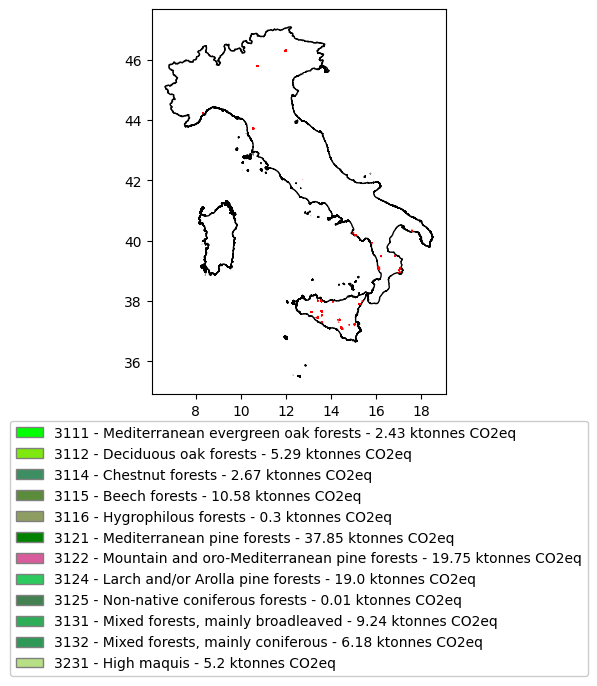

2025-07-08 14:08:07,729 - INFO - Created 60 records


2095.6748804802905
Processing for year 2019
total burn events: 439


2025-07-08 14:10:46,817 - INFO - Function 'intersect_vectors' executed in 22.6975 seconds.


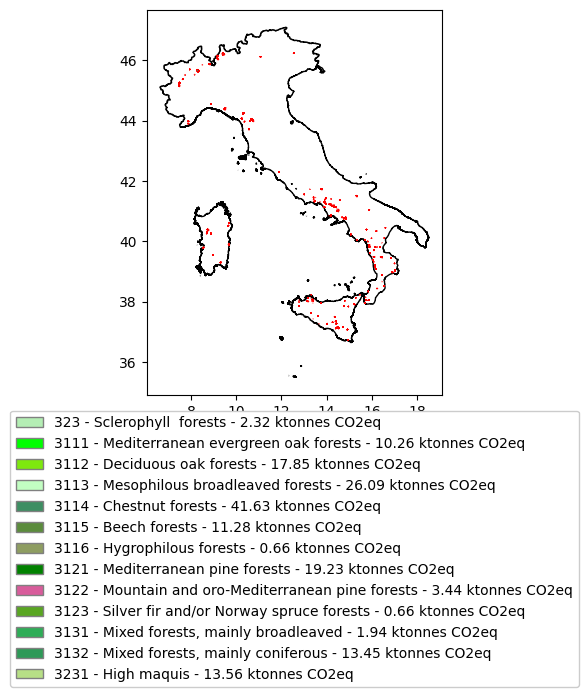

2025-07-08 14:11:21,884 - INFO - Created 225 records


3285.115916711909
Processing for year 2020
total burn events: 1117


2025-07-08 14:16:22,599 - INFO - Function 'intersect_vectors' executed in 54.0693 seconds.


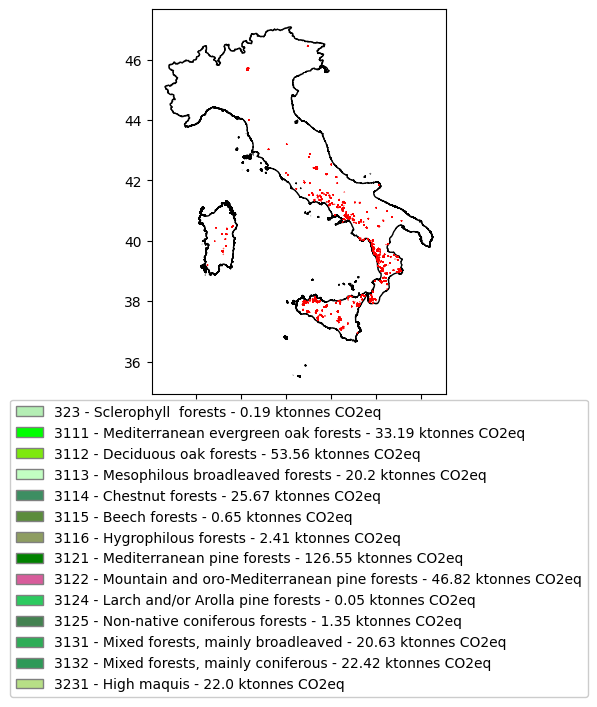

7685.654984218717


2025-07-08 14:17:28,867 - INFO - Created 562 records


Processing for year 2021
total burn events: 1407


2025-07-08 14:26:34,281 - INFO - Function 'intersect_vectors' executed in 212.0838 seconds.


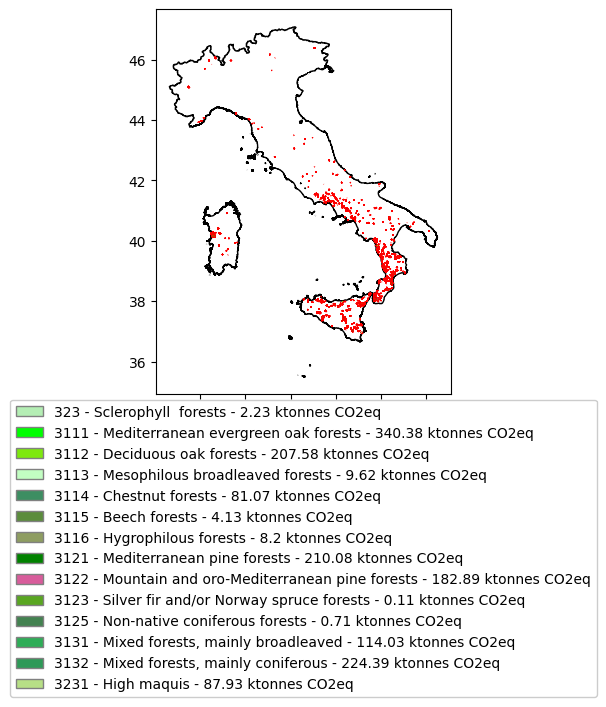

26418.705292534698


2025-07-08 14:30:22,237 - INFO - Created 1,007 records


Processing for year 2022
total burn events: 1419


2025-07-08 14:37:06,112 - INFO - Function 'intersect_vectors' executed in 68.7090 seconds.


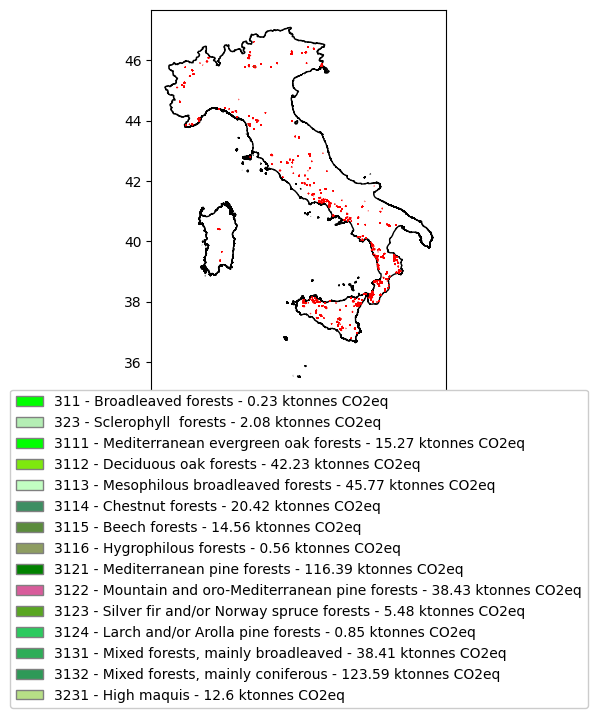

7582.394104030773


2025-07-08 14:38:06,699 - INFO - Created 688 records


Data saved


In [14]:
all_data = []

def main(year, fire_id=None):
    print(f"Processing for year {year}")

    # SHAPEFILES
    path_to_fire_severity_shapefile = "../data/rasters/fire_severity/processed/shp/severity_"+str(year)+"_italy.shp"        

    
    # Step 1: Import Data
    effis_ba = import_data(path_to_effis_shapefile, year, fire_id)
    burnt_shape, border_shape = crop_shapefile(path_to_country_shapefile,
                                path_to_regions_shapefile,
                                path_to_provinces_shapefile,
                                path_to_communes_shapefile,
                                effis_ba,
                                country="IT")

  
    tot_events = len(burnt_shape)
    print("total burn events:", len(burnt_shape))

    forest_classes, forest_labels, forest_colors = get_landcover_classes(landcover,path_to_landcover_legend_table,language)

    #Step 4: Calculate biomass
    B = get_biomass_in_burnt_shape(path_to_biomass_raster, path_to_biomass_std_raster, path_to_clc18_shapefile, burnt_shape, crs, landcover)

    ABC = get_combustion_factor(path_to_fire_severity_shapefile, B, 
                          path_to_forest_classes_table, path_to_C_factor_table, landcover, crs,
                              language)


    # Step 5. Get combustion factor (C) for each vegetation type
    D = get_emission_factors(path_to_emission_factors_table)
        
    # Step 7. Calculate total GHG emissions from emission factors
    ghg_total, ghg_total_std, df_ghg_all_fires = get_total_ghg_emissions(ABC,D,landcover)

    #plot 
    results=plot_map(forest_classes, forest_labels, forest_colors, border_shape,
                                        language,burnt_shape,df_ghg_all_fires,crs,
                                        path_to_shapefile_output=None,plot_border=True)

    ghg_all_fires_shp = get_info_each_fire_event(df_ghg_all_fires)
     #save results
    data = save_total_ghg_emissions(ghg_total, ghg_total_std, df_ghg_all_fires, year, country, region, province, commune, tot_events)

    print(data["Burn area (ha)"])    
    return data, ghg_all_fires_shp

for y in range(2018,2023):
    data, shp = main(y)
    all_data.append(data)
    shp.to_file("../outputs/GHG_EMISSIONS_DATABASE/shp/IT_"+str(y)+"ESA_CCI.shp")
    
# Convert the results to a DataFrame
df_results = pd.DataFrame(all_data)

    
# Save to CSV
path_total_output = "../outputs/GHG_EMISSIONS_DATABASE/IPCC2006_EF/ghg_emissions_Italy_2018_2022_ESA_BIOMASS.csv"

df_results.to_csv(path_total_output )
print(f"Data saved")